In [342]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import cartopy.feature as cf
import cartopy.crs as ccrs

In [343]:
shp_pan = gpd.read_file(r'Data\amazon\panamz.geojson')

# Peru

In [166]:
peru_raw = pd.read_csv(r"Data_stations\Countries\peru\peru_raw_441.csv")
# tranform the dates in one column
peru = peru_raw.melt(id_vars=['name', 'x', 'y'], var_name='Date', value_name='Total')
# transform the date column to datetime
peru['Date'] = pd.to_datetime(peru['Date'])
peru.rename(columns={'name': 'Code'}, inplace=True)
#in peru Code let just numeric values
peru['Code'] = peru['Code'].str.extract('(\d+)', expand=False).astype(int)
df_peru = peru[['Code','Date', 'Total']]
gdf_peru = peru.drop_duplicates(subset=['Code'])[['Code', 'x', 'y']]
gdf_peru = gpd.GeoDataFrame(gdf_peru, geometry=gpd.points_from_xy(gdf_peru.x, gdf_peru.y))[['Code', 'geometry']]

In [167]:
#save df_peru and gdf_peru
df_peru.to_csv(r'Data_stations\Countries\peru\peru.csv', index=False)
gdf_peru.to_file(r'Data_stations\Countries\peru\peru.geojson', driver='GeoJSON')

# Colombia

In [12]:
## clean and merge the stations dfs

#raw_folder = r'Data_stations\colombia\raw'
#files = glob(raw_folder + "/*.data")
##open file with pandas
#li= []
#for file in files:
#
#    code_stat = file.split('@')[-1].split('.')[0]
#    df = pd.read_csv(file, sep='|')
#    df = df.rename(columns={'Fecha': 'Date', 'Valor': 'Total'})
#    df['Date'] = pd.to_datetime(df['Date'])
#    #exclude the hours from Date
#    df['Date'] = df['Date'].dt.date
#    df = df.set_index('Date')
#    df.index = pd.to_datetime(df.index)
#    df = df.resample('1MS').sum().reset_index()
#    df['Code'] = code_stat
#    li.append(df)
#
#df_col = pd.concat(li, axis=0, ignore_index=True).sort_values(by=['Code','Date']).reset_index(drop=True)
#df_col.to_csv(r'Data_stations\Countries\colombia_all.csv', index=False)


In [179]:
df_col = pd.read_csv(r'Data_stations\Countries\colombia\colombia_all.csv')
stats = pd.read_excel(r"Data_stations\Countries\colombia\CNE_IDEAM.xls")
#create a gdf stats
gdf_col = gpd.GeoDataFrame(stats, geometry=gpd.points_from_xy(stats['longitud'], stats['latitud']))[['CODIGO', 'geometry']].set_crs(epsg=4326)
# select gdf_col where the code is in df_col
gdf_col = gdf_col[gdf_col['CODIGO'].isin(df_col['Code'])]
gdf_col = gdf_col.rename(columns={'CODIGO': 'Code'}).reset_index(drop=True)

In [181]:
#save df_col and gdf_col
df_col.to_csv(r'Data_stations\Countries\colombia\colombia.csv', index=False)
gdf_col.to_file(r'Data_stations\Countries\colombia\colombia.geojson', driver='GeoJSON')

# meteostat


In [62]:
from meteostat import Stations
from meteostat import Monthly
stations = Stations()
#stations in south america
met_sa_all = stations.bounds((15, -80), (-50, -34)).fetch()
#create gdf
gdf_met_sa = gpd.GeoDataFrame(met_sa_all, geometry=gpd.points_from_xy(met_sa_all['longitude'], met_sa_all['latitude']))
#where there is monthly data, and rename columns, and drop duplicates
met_sa_select = met_sa_all[met_sa_all['monthly_start'].notna()].reset_index()[['name','wmo', 'geometry']].rename(columns={'name': 'Name', 'wmo': 'Code'}).drop_duplicates(subset='Code').dropna()

In [115]:
data = Monthly(met_sa_select.Code.unique().tolist()).fetch()

In [171]:
data = data.reset_index()[['station','time', 'prcp']]
data.rename(columns={'station': 'Code', 'time': 'Date', 'prcp': 'Total'}, inplace=True)
data.to_csv(r'Data_stations\Countries\meteostat\meteostat.csv', index=False)
#select only stations in met_sa_select that are in data
met_sa_select = met_sa_select[met_sa_select['Code'].isin(data['Code'])]
#transform to gdf
gdf_met_sa = gpd.GeoDataFrame(met_sa_select, geometry=met_sa_select.geometry)
#save as geojson
gdf_met_sa.to_file(r'Data_stations\Countries\meteostat\meteostat.geojson', driver='GeoJSON')

# bolivia

In [232]:
## clean and merge the stations dfs

raw_folder = r'Data_stations\Countries\bolivia\shps'
files = glob(raw_folder + "/*.shp")

In [260]:
##open file with pandas
li= []
for file in files:

    gdf = gpd.read_file(file)
    li.append(gdf)
#
df_bol_files = pd.concat(li, axis=0, ignore_index=True)


In [331]:
df_bol_all = df_bol_files.rename(columns={'ID_ESTACIO': 'Code', 'TIME': 'Date', 'VALOR_VARI': 'Total', 'ESTACION': 'Name'})[['Code', 'Date', 'Total', 'Name', 'geometry']]
#just numeric values in Total
df_bol_all['Total'] = df_bol_all['Total'].str.extract('(\d+)', expand=False).astype(int)
df_bol_all['Date'] = pd.to_datetime(df_bol_all['Date'])
df_bol_all = df_bol_all.drop_duplicates(subset=['Code', 'Date'])
df_bol_all.reset_index(drop=True, inplace=True)
#delete rows with '(Satelital)' or '(GPRS)' in the Name
df_bol_all = df_bol_all[~df_bol_all['Name'].str.contains('Satelital|GPRS').fillna(False)]
#drop where geometry is nan
df_bol_all= df_bol_all.dropna(subset=['geometry'])

df_bol = df_bol_all[['Code', 'Date', 'Total']]

In [339]:
#create gdf file
gdf_bol = gpd.GeoDataFrame(df_bol_all, geometry=df_bol_all.geometry)
#drop duplicates
gdf_bol = gdf_bol.drop_duplicates(subset=['Code']).reset_index(drop=True)[['Code','Name', 'geometry']]

In [341]:
#save df and gdf
df_bol.to_csv(r'Data_stations\Countries\bolivia\bolivia.csv', index=False)
gdf_bol.to_file(r'Data_stations\Countries\bolivia\bolivia.geojson', driver='GeoJSON')

# UNITE

## stations

In [602]:
gdf_ana = gpd.read_file('Data\stations.geojson')
gdf_peru = gpd.read_file(r'Data_stations\Countries\peru\peru.geojson')
gdf_col = gpd.read_file(r'Data_stations\Countries\colombia\colombia.geojson')
gdf_bol = gpd.read_file(r'Data_stations\Countries\bolivia\bolivia.geojson')
gdf_met_sa = gpd.read_file(r'Data_stations\Countries\meteostat\meteostat.geojson')
gdf_bol['Code'] = gdf_bol['Code'] * 1000000
#create a Name column in gdf_peru with 'Station' + Code
gdf_peru['Name'] = 'Station ' + gdf_peru['Code'].astype(str)


In [603]:
#concat all gdf
gdf_all = pd.concat([gdf_ana, gdf_peru, gdf_col, gdf_bol, gdf_met_sa], ignore_index=True)[['Code', 'Name', 'geometry']]
gdf_all['Code'] = gdf_all['Code'].astype(float)

## frames

In [604]:
#unite all. criar consistencia. check pikle.
frame_ana = pd.read_pickle('Data\ANA_clean.pkl')
frame_peru = pd.read_csv(r'Data_stations\Countries\peru\peru.csv')
frame_col = pd.read_csv(r'Data_stations\Countries\colombia\colombia.csv')
frame_bol = pd.read_csv(r'Data_stations\Countries\bolivia\bolivia.csv')
frame_met_sa = pd.read_csv(r'Data_stations\Countries\meteostat\meteostat.csv')
frame_bol['Code'] = frame_bol['Code'] * 1000000
#create consistency column for all frames except frame_ana
frame_peru['Consistency'] = 1
frame_col['Consistency'] = 1
frame_bol['Consistency'] = 1
frame_met_sa['Consistency'] = 1
#concat all frames
frames = [frame_ana, frame_peru, frame_col, frame_bol, frame_met_sa]
df_all = pd.concat(frames, ignore_index=True).dropna()
#fix Date
df_all['Date'] = pd.to_datetime(df_all['Date'])


In [605]:
#drop duplicates in Code and Date
const = df_all.sort_values(by='Consistency').drop_duplicates(subset=['Code','Date'], keep='first')
sizes = const.groupby('Code').size().reset_index(name='counts')
#select only the codes that have more than 100 counts
codes_data = sizes[sizes['counts'] > 100]['Code'].tolist()

In [606]:
gdf_all = gdf_all[gdf_all['Code'].isin(codes_data)].sort_values(by='Code').reset_index(drop=True)
#select df_all where Code is in gdf_all
df_all = df_all[df_all['Code'].isin(gdf_all['Code'])].sort_values(by='Code').reset_index(drop=True)

In [607]:
# create lat lon columns in gdf_all from geometry
gdf_all['Latitude'] = gdf_all['geometry'].x
gdf_all['Longitude'] = gdf_all['geometry'].y
#create date begin and date end in gdf_all from df_all data
gdf_all['Date_begin'] = df_all.groupby('Code')['Date'].min().reset_index()['Date']
gdf_all['Date_end'] = df_all.groupby('Code')['Date'].max().reset_index()['Date']
#drop rows with data end before 2005
gdf_05 = gdf_all[gdf_all['Date_end'] > '2005-01-01'].reset_index(drop=True)
#drop rows with data begin after 2004
gdf_05 = gdf_05[gdf_05['Date_begin'] < '2005-01-01'].reset_index(drop=True)

In [608]:
gdf = gdf_05.sort_values(by='Code').reset_index(drop=True).copy()
#df_all with code in gdf
df_all = df_all[df_all['Code'].isin(gdf['Code'])].sort_values(by='Code').reset_index(drop=True)

In [615]:
#save gdf and df
gdf.to_file(r'Data\all_stations.geojson', driver='GeoJSON')
df_all.to_pickle(r'Data\all_clean.pkl')


In [610]:
#df all in the 2000-2020
df_test = df_all[df_all['Date'] > '2000-01-01'].reset_index(drop=True)
df_test = df_test[df_test['Date'] < '2020-01-01'].reset_index(drop=True)
sizes = df_test.groupby('Code').size().reset_index(name='counts')

In [611]:
#merge gdf_05 with sizes
gdf_aa = gdf_05.merge(sizes, on='Code', how='left')

In [612]:
#gdfaa counts divide by 12
gdf_aa['counts'] = gdf_aa['counts'] / 12

In [613]:
gdf_aa_pan = gpd.sjoin(gdf_aa, shp_pan, how='inner', op='intersects')

Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674



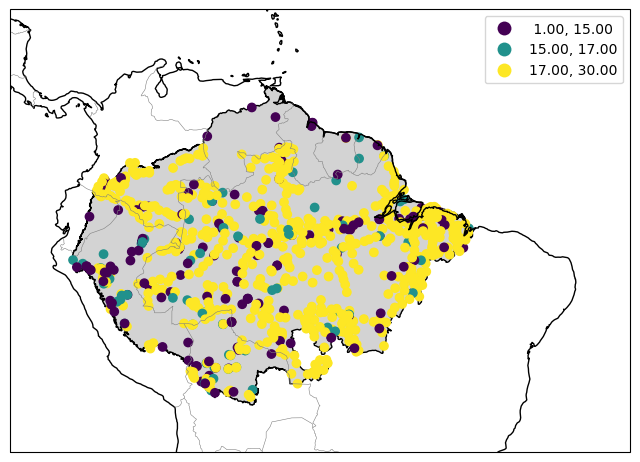

In [614]:
fig, ax = plt.subplots(1,1, figsize=(8,8), subplot_kw={'projection': ccrs.PlateCarree()})
shp_pan.plot(ax=ax, color='lightgrey', edgecolor='black')
ax.coastlines()
# plot also the number of stations
ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
gdf_aa_pan.plot(column='counts', legend=True,  cmap='viridis', ax=ax,  scheme='user_defined', classification_kwds={'bins':[15,17,30]})
ax.set_extent([-85, -30, -20, 15])